In [1]:
import cv2
import os
import numpy as np
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Dense, Activation, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Reshape, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, GlobalMaxPooling2D


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
train_path = '/kaggle/input/garbage-classification-v2/Garbage Classification'

def load_dataset(path, target_shape):
    class_folders = os.listdir(path)
    filenames = []
    labels = []

    for i, class_folder in enumerate(class_folders):
        folder_path = os.path.join(path, class_folder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            try:
                image = cv2.imread(image_path)
                if image is None:
                    continue  # Skip non-image files
                resized_image = cv2.resize(image, target_shape[:2])
                filenames.append(resized_image)
                labels.append(i)
            except Exception as e:
                print(f"Error processing image: {image_path} - {e}")

    X = np.array(filenames)
    y = np.array(labels)

    # Normalize pixel values
    X = X.astype('float32') / 255.0

    # Convert labels to categorical
    y = np_utils.to_categorical(y)

    return X, y


# Define the target shape for resizing images
target_shape = (110, 110, 3)

# Load and preprocess the dataset
X, y = load_dataset(train_path, target_shape)

# Split the dataset into training, testing, and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print("Shape of X_train, y_train:", X_train.shape, y_train.shape)
print("Shape of X_test, y_test:", X_test.shape, y_test.shape)
print("Shape of X_val, y_val:", X_val.shape, y_val.shape)

    

libpng warning: Out of place sRGB chunk
libpng warning: Out of place sRGB chunk
libpng warning: Out of place sRGB chunk
libpng warning: Out of place sRGB chunk


Shape of X_train, y_train: (15827, 110, 110, 3) (15827, 10)
Shape of X_test, y_test: (4397, 110, 110, 3) (4397, 10)
Shape of X_val, y_val: (1759, 110, 110, 3) (1759, 10)


In [3]:
# Define the model architecture
MainInput = Input(shape=target_shape)
dn169 = DenseNet169(weights='imagenet', include_top=False, input_shape=target_shape, pooling='avg')(MainInput)
reshape = Reshape((8,8,26))(dn169)

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D


def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Dense(filters // se_ratio, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='softmax')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x


conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)

image_size_2 = 8
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_2, image_size_2, 128,))(conv)
x = squeeze_excite_block(conv, 128, 128)

conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)

conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))

conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)

image_size_3 = 4
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_3, image_size_3, 256,))(conv)
x = squeeze_excite_block(conv, 256, 256) 


conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)

conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv = Dense(y_train.shape[1], activation="softmax")(conv)

model_dn169 = Model(inputs=MainInput, outputs=conv)
model_dn169.summary()

51877672/51877672 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 110, 110, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet169 (Functional)       (None, 1664)         12642880    ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 8, 8, 26)     0           ['densenet169[0][0]']            
                                                                                                  
 conv2d (Conv2D)             

In [4]:
# Compile the model
model_dn169.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, epsilon=0.1), metrics=['accuracy'])

# Set up a checkpoint to save the best model
checkpoint = ModelCheckpoint('/kaggle/working/model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=25, min_delta=0.001)

# Record the start time
import time
start_time = time.time()

# Train the model
history = model_dn169.fit(X_train, y_train,
                          epochs=25,
                          batch_size=12,
                          validation_data=(X_val, y_val),
                          callbacks=[checkpoint, early_stopping])

# Calculate the total training time
end_time = time.time()
total_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(total_time))

1319/1319 [==============================] - 145s 88ms/step - loss: 1.4238 - accuracy: 0.5202 - val_loss: 0.6799 - val_accuracy: 0.7840
Total training time: 166.28 seconds


Number of epochs trained: 1


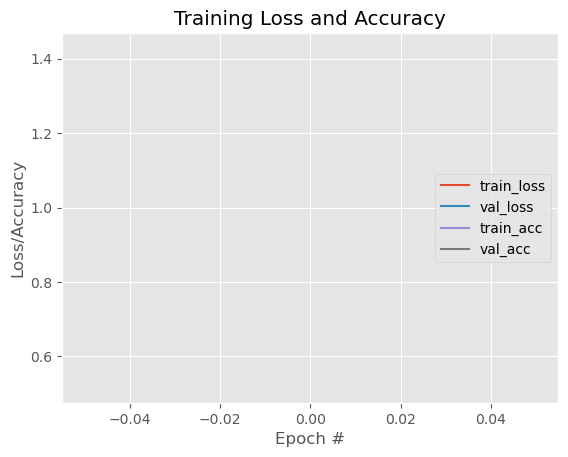

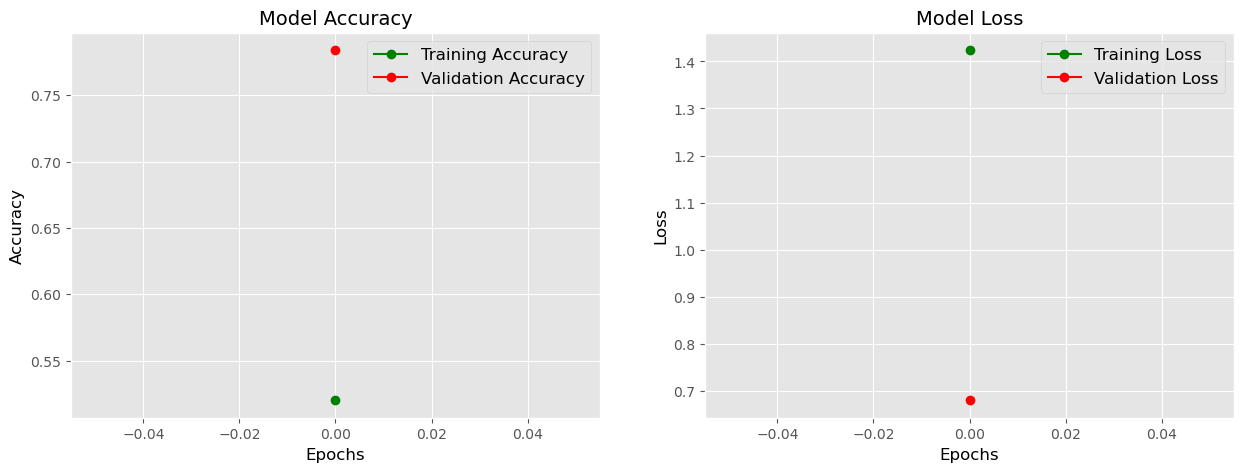

In [5]:
# Load the best weights
model_dn169.load_weights('/kaggle/working/model.h5')

# Plot the training loss and accuracy
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("DenseNet169_Model")

# Determine number of epochs trained
num_epochs_trained = len(history.history['val_loss'])
print(f"Number of epochs trained: {num_epochs_trained}")

# History plotting
epochs = [i for i in range(num_epochs_trained)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(15, 5)

# Plotting accuracy
ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
title_font = {'fontname': 'Times New Roman', 'size': '14', 'color': 'black', 'weight': 'normal'}
ax[0].set_title('Model Accuracy', fontdict=title_font)
legend_font = {'family': 'Times New Roman', 'size': '12', 'weight': 'normal'}
ax[0].legend(prop=legend_font)
label_font = {'fontname': 'Times New Roman', 'size': '12', 'color': 'black', 'weight': 'normal'}
ax[0].set_xlabel("Epochs", fontdict=label_font)
ax[0].set_ylabel("Accuracy", fontdict=label_font)

# Plotting loss
ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Model Loss', fontdict=title_font)
ax[1].legend(prop=legend_font)
ax[1].set_xlabel("Epochs", fontdict=label_font)
ax[1].set_ylabel("Loss", fontdict=label_font)

plt.show()

In [6]:
# Evaluate the model on the test set
val_loss, val_accuracy = model_dn169.evaluate(X_test, y_test, verbose=0)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)




Test loss: 0.6709877252578735
Test accuracy: 0.7864453196525574


In [7]:
# Make predictions on the test set
y_pred = model_dn169.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels
y_test_labels = np.argmax(y_test, axis=1)

# Generate classification report
#class_folders = os.listdir(train_path)
#class_names = class_folders
report = classification_report(y_test_labels, y_pred)
print(report)


138/138 [==============================] - 8s 35ms/step
              precision    recall  f1-score   support

           0       0.54      0.77      0.63       346
           1       0.86      0.74      0.79       792
           2       0.70      0.86      0.77       235
           3       0.85      0.52      0.64       421
           4       0.98      0.45      0.61       185
           5       0.76      0.52      0.62       132
           6       0.74      0.89      0.81       389
           7       0.80      0.91      0.85       387
           8       0.84      0.98      0.90      1065
           9       0.84      0.67      0.75       445

    accuracy                           0.79      4397
   macro avg       0.79      0.73      0.74      4397
weighted avg       0.80      0.79      0.78      4397



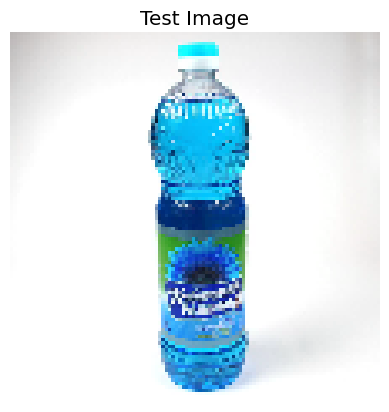

1/1 [==============================] - 0s 41ms/step
True class: plastic
Predicted class: plastic


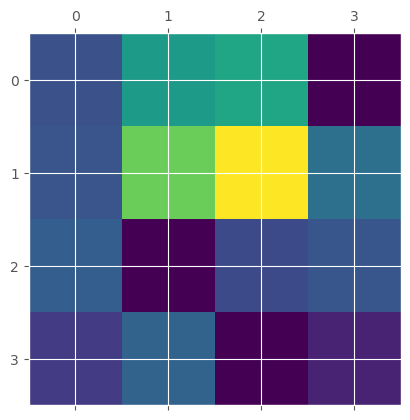

/tmp/ipykernel_28/2843796947.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


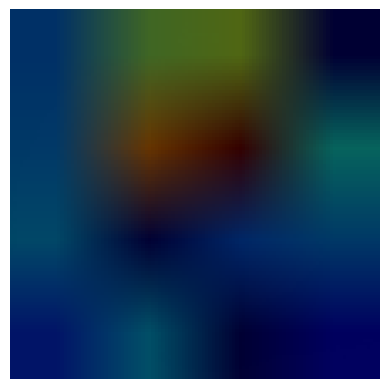

In [49]:
import matplotlib.cm as cm
from PIL import Image

def get_img_array(img_path, size):
    img = Image.open(img_path)
    img = img.resize(size)
    array = np.array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def plot_gradcam(img_array, heatmap, alpha=0.4):
    img = np.squeeze(img_array)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")

    # Apply the colormap to the heatmap
    jet_colors = jet(heatmap)
    jet_heatmap = jet_colors[..., :3]
    jet_heatmap = np.asarray(jet_heatmap) * 255

    # Resize heatmap to match the image size
    resized_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img.astype('uint8'), 1 - alpha, resized_heatmap.astype('uint8'), alpha, 0)

    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()
    
    
# Select an image from the test set
index = 0
image = X_test[index]
label = np.argmax(y_test[index])

# Show the test image
plt.imshow(image)
plt.title("Test Image")
plt.axis("off")
plt.show()

# Preprocess the image
image = np.expand_dims(image, axis=0)
class_names = os.listdir(train_path)
# Perform prediction
predictions = model_dn169.predict(image)
predicted_class_index = np.argmax(predictions[0])
predicted_class = class_names[predicted_class_index]



# Print the predicted class and the true class
true_class = class_names[label]
print("True class:", true_class)
print("Predicted class:", predicted_class)

# Generate class activation heatmap
last_conv_layer_name = 'conv2d_15'
heatmap = make_gradcam_heatmap(image, model_dn169, last_conv_layer_name, pred_index=predicted_class_index)

# Display the heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose the heatmap on the original image
plot_gradcam(image, heatmap, alpha=0.4)